In [1]:
import geopandas as gpd

In [2]:
import os, re
from datetime import date, datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import timeit

In [3]:
path = r'G:\projects\UtilityDistricts\eweb\DrinkingWater\EPA319_NPS_grant\ForestApplication\ODF_FACTS_DB\FERNS\FERNS_Model'

In [4]:
inpath = path + '\\FERNS_Model_Intermediate.gdb'

In [5]:
FERNS = gpd.read_file(inpath, driver = 'FileGDB', layer = 'ReProjected')

In [6]:
FERNS.columns

Index(['NoapID', 'UnitID', 'NoapIdentifier', 'WorkArea', 'OperationName',
       'OperatorName', 'UnitName', 'UnitArea', 'ActType', 'LandOwners',
       'StartDate', 'EndDate', 'ActivityID', 'HighwayBuffer', 'SummaryLink',
       'PDFLink', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

In [7]:
# selected activity types, first the types included on the dashboard, then the types used in Kyle's table
# sel_actypes = ['Changing Land Use to a non-forest use', 'Clearcut/Overstory Removal', 
#                'Clearing for Homesites/Other development', 'Commercial Thinning/Selective Cutting',
#               'Fertilizer Application', 'Herbicide Application (Unit)', 'Salvage', 'Precommercial Thinning',
#               'Fungicide Application', 'Insecticide Application']
sel_actypes = ['Herbicide Application (Unit)', 'Clearcut/Overstory Removal', 'Salvage']

In [8]:
# check if the spellings are all corrected
all([acty in FERNS.ActType.unique() for acty in sel_actypes])

True

In [9]:
# the original spatial reference
FERNS.crs

<Projected CRS: EPSG:2914>
Name: NAD83(HARN) / Oregon South (ft)
Axis Info [cartesian]:
- X[east]: Easting (foot)
- Y[north]: Northing (foot)
Area of Use:
- name: United States (USA) - Oregon - counties of Coos; Crook; Curry; Deschutes; Douglas; Harney; Jackson; Josephine; Klamath; Lake; Lane; Malheur.
- bounds: (-124.6, 41.98, -116.9, 44.56)
Coordinate Operation:
- name: SPCS83 Oregon South zone (International feet)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
McK_basins = gpd.read_file(path + '\\FERNS_Model_Input.gdb', driver = 'FileGDB', layer = 'McKenzie_Catchments_Input')

In [11]:
FERNS_s = FERNS[FERNS.ActType.isin(sel_actypes)]

In [12]:
McK_basins.columns

Index(['Basin_Name', 'EWEB_ID', 'Shape_Length', 'Shape_Area', 'Subbasin_Acres',
       'geometry'],
      dtype='object')

In [13]:
# make sure there are not duplicated basin names
len(McK_basins.Basin_Name.unique()) == McK_basins.shape[0]

True

In [14]:
# tried intersect first but it works differently in geopandas; chose clip that matches with intersect in ArcGIS Pro
FERNS_in_Mck_basins = pd.DataFrame()
# select FERNS data within McKenzie catchments
for basin in McK_basins.Basin_Name.unique():
    #idx = McK_basins[McK_basins.Basin_Name == basin].index[0]
    #intersected = FERNS_s[FERNS_s['geometry'].intersects(McK_basins['geometry'].values[idx])]
    intersected = gpd.clip(FERNS_s, McK_basins[McK_basins.Basin_Name == basin])
    intersected['Basin_Name'] = basin
    FERNS_in_Mck_basins = FERNS_in_Mck_basins.append(intersected, ignore_index=True)

In [15]:
# convert square feet to acres
FERNS_in_Mck_basins['acres'] = FERNS_in_Mck_basins.area / 43560

In [16]:
FERNS_in_Mck_basins['year'] = FERNS_in_Mck_basins.EndDate.apply(lambda x: x.split('-')[0])

In [17]:
# report data to see the patterns and export data
data_overview = FERNS_in_Mck_basins.groupby(['year', 'ActType']).agg({'acres': ['sum', 'mean', 'min', 'max']})
data_overview_by_basin = FERNS_in_Mck_basins.groupby(['year', 'ActType', 'Basin_Name']).agg({'acres': 'sum'})

In [18]:
data_overview.columns = list(map(lambda x: x[0] + '_' + x[1], list(data_overview.columns)))

In [19]:
data_overview_by_basin_reidx = data_overview_by_basin.reset_index()

In [27]:
data_overview_by_basin_reidx.head(3)

,year,ActType,Basin_Name,acres
0,2014,Clearcut/Overstory Removal,Camp Creek,23.210036
1,2014,Clearcut/Overstory Removal,Gate Creek,16.123516
2,2014,Clearcut/Overstory Removal,Headwaters Mohawk River,55.728350


In [20]:
testdt = data_overview_by_basin.unstack('ActType').unstack('year').sort_index(axis=1, ascending=False)

In [22]:
testdt = testdt.sort_index(axis=0, ascending=True)

In [26]:
testdt.to_csv(path+'\\output\\FERNS_' + str(date.today()).replace('-', '') + '.csv', index=True)

In [24]:
data_overview_by_basin_reidx.Basin_Name.unique()

array(['Shotcash Creek-Mohawk River', 'Camp Creek', 'Gate Creek',
       'Headwaters Mohawk River', 'McKenzie_E110', 'Walterville Canal',
       'Mill Creek', 'Blue River', 'McGowan Creek-Mohawk River',
       'McKenzie_E020', 'Parsons Creek-Mohawk River', 'Quartz Creek',
       'Cogswell Creek', 'Hatchery Creek', 'Marten Creek',
       'McKenzie_E130', 'East Springfield_East',
       'Boulder Creek - Walterville', 'Cedar Creek', 'Deer Creek_Vida',
       'Elk Creek', 'Ennis Creek', 'Forest Creek', 'Haagen Creek',
       'Johnson Creek', 'McKenzie  River', 'McKenzie Leaburg Lake',
       'McKenzie/Honey Creek', 'McKenzie_E010', 'McKenzie_E150',
       'McKenzie_E170', 'McKenzie_E180', 'Ritchie Creek',
       'South Fork McKenzie', 'Taylor Creek_Walterville', 'Trout Creek',
       'Boulder Creek', 'Deer Creek', 'East Springfield_West',
       'Finn Creek', 'Goose Creek', 'Holden Creek', 'Horse Creek',
       'Indian Creek', 'Lane Creek', 'Lost Creek', 'McKenzie_E040',
       'McKenzie_E

In [68]:
# this table includes all the same selected activity types to compare with dashboard data
data_overview_by_basin_reidx.to_csv(path+'\\output\\data_overview_20230127.csv', index=False)

In [61]:
# compare the numbers with the same process in ArcGIS Pro
data_overview_by_basin_reidx[(data_overview_by_basin_reidx.ActType=='Herbicide Application (Unit)') & (data_overview_by_basin_reidx.Basin_Name == 'Headwaters Mohawk River')]

,year,ActType,Basin_Name,acres
124,2015,Herbicide Application (Unit),Headwaters Mohawk River,1597.544012
291,2016,Herbicide Application (Unit),Headwaters Mohawk River,2762.217643
461,2017,Herbicide Application (Unit),Headwaters Mohawk River,1979.874062
626,2018,Herbicide Application (Unit),Headwaters Mohawk River,1944.375489
788,2019,Herbicide Application (Unit),Headwaters Mohawk River,1823.866433
957,2020,Herbicide Application (Unit),Headwaters Mohawk River,1407.565212
1129,2021,Herbicide Application (Unit),Headwaters Mohawk River,3346.722098
1285,2022,Herbicide Application (Unit),Headwaters Mohawk River,8776.238982


In [62]:
dt=data_overview[['acres_sum']].unstack('ActType')

In [63]:
dt.columns = list(map(lambda x: x[1], list(dt.columns)))

In [ ]:
#dt = dt.reset_index()

In [64]:
dt

,Changing Land Use to a non-forest use,Clearcut/Overstory Removal,Clearing for Homesites/Other development,Commercial Thinning/Selective Cutting,Fertilizer Application,Herbicide Application (Unit),Precommercial Thinning,Salvage
year,,,,,,,,
2014,0.236073,136.031723,0.149426,106.909272,NaN,229.681021,208.555876,5.544501
2015,29.866320,4601.020331,0.814134,7027.079752,2354.957849,14462.709220,1015.482376,437.030709
2016,36.618890,6530.145370,1.991811,9777.607344,3901.648745,15008.831272,752.329668,2946.145995
2017,16.353894,4619.741716,39.973610,4734.690513,6805.054594,15442.077882,497.134204,822.952092
2018,13.390821,5454.737772,12.276279,6397.871547,6831.624491,13652.424131,1128.254733,750.964541
2019,11.321773,4385.317357,7.327209,4133.191226,11148.033775,13539.148723,999.790679,3167.645517
2020,0.490270,7363.204119,21.928048,5837.534524,NaN,11739.128405,597.462985,40005.038448
2021,NaN,5155.430916,8.889721,2301.640018,NaN,25429.702953,149.833193,16360.792705
2022,NaN,3699.697572,13.656418,3547.202597,NaN,68046.502313,2695.331342,4112.327843


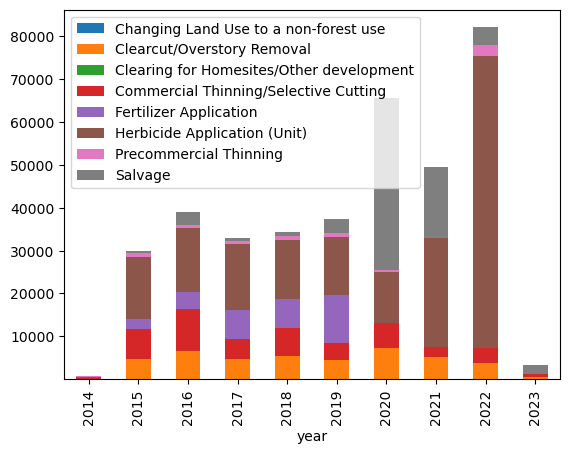

In [65]:
dt.plot.bar(stacked=True);

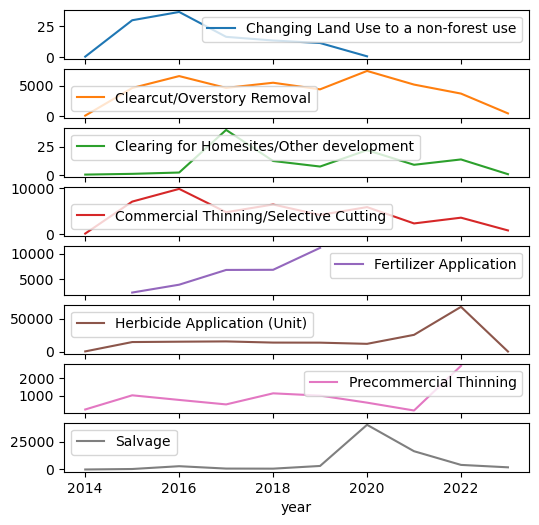

In [66]:
dt.plot(subplots=True, figsize=(6, 6));

In [95]:
# run to export the data from different download times to see whether historical data has been changed
# it takes about five minutes
start = timeit.default_timer()
for geodb in geodbs:
    FERNS = gpd.read_file(geodb, driver = 'FileGDB', layer = 'Ferns_Noaps_Polygons')
    FERNS = FERNS.to_crs(epsg=2914)
    FERNS_s = FERNS[FERNS.ActType.isin(['Herbicide Application (Unit)', 'Clearcut/Overstory Removal'])]
    FERNS_s['year'] = FERNS_s.EndDate.apply(lambda x: x.split('-')[0])
    FERNS_in_Mck_basins = pd.DataFrame()
    for basin in McK_basins.Basin_Name.unique():
        intersected = gpd.clip(FERNS_s, McK_basins[McK_basins.Basin_Name == basin])
        intersected['Basin_Name'] = basin
        FERNS_in_Mck_basins = FERNS_in_Mck_basins.append(intersected, ignore_index=True)
    
    dateinfo = geodb.split('_')[-1].split('.gdb')[0]
    FERNS_in_Mck_basins['acres'] = ((FERNS_in_Mck_basins.area / 43560) + 0.5).astype(int)
    data_overview_by_basin = FERNS_in_Mck_basins.groupby(['year', 'ActType', 'Basin_Name']).agg({'acres': 'sum'})
    data_overview_by_basin_reidx = data_overview_by_basin.reset_index()
    dt = data_overview_by_basin.unstack('ActType').unstack('year').sort_index(axis=1, ascending=False)
    dt = dt.sort_index(axis=0, ascending=True)
    dt.to_csv(path+'\\output\\data_overview_' + dateinfo + '.csv', index=True)
    print(f"Processed data on {dateinfo}")
stop = timeit.default_timer()
print(stop - start)

C:\Users\clid1852\AppData\Anaconda3\envs\geoenv\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Processed data on 01092023
Processed data on 01272023
Processed data on 10142022
Processed data on 11012022
Processed data on 12072022
296.60868670000036
